# PyMC tutorial

In this notebook, we will go through the PyMC tutorial. 

Source: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html#glm-linear


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import pymc as pm

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.17.0


In [2]:
# Set the random seed   
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

### Generating data

Let's simulate we have a bunch of data points that follow a linear relationship.


In [3]:
size = 200
true_intercept = 1
true_slope = 2

def f(x, intercept, slope):
    return intercept + slope * x

x = np.linspace(0, 1, size)
true_regression_line = f(x, true_intercept, true_slope)
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

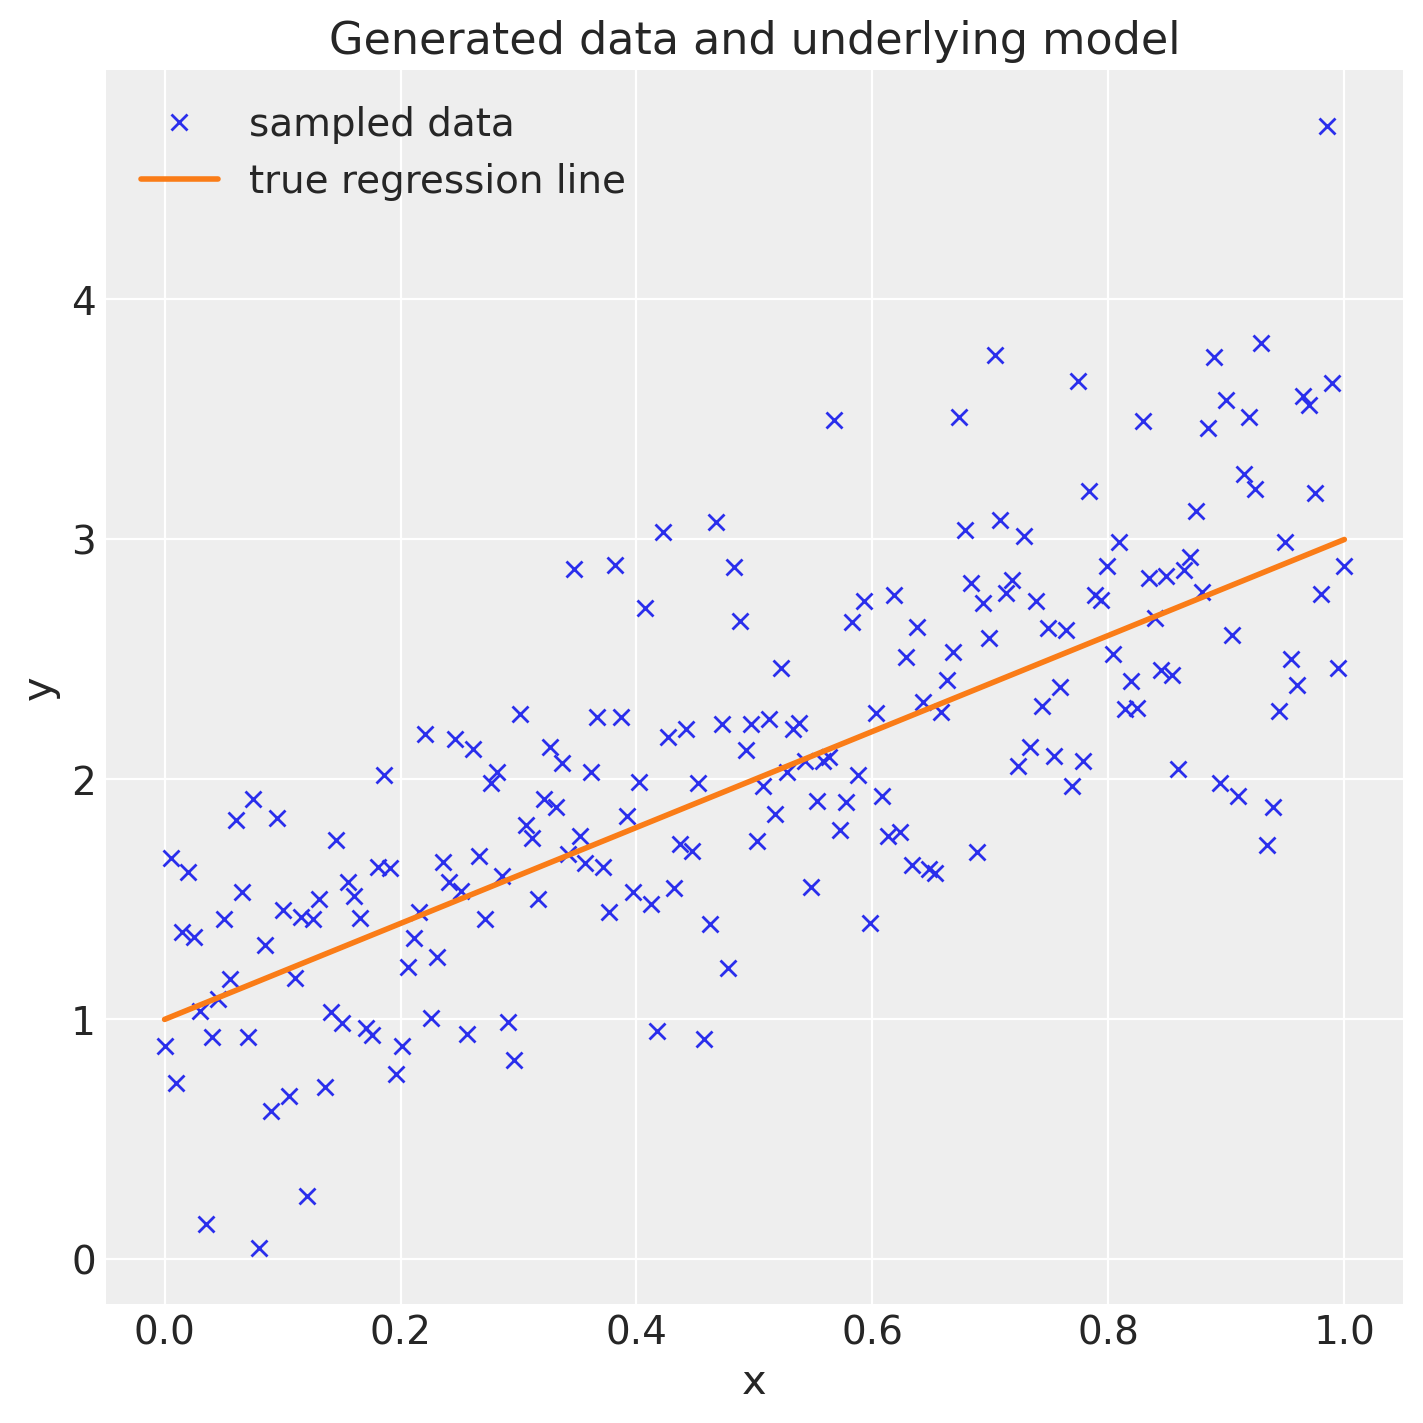

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

### Estimating the model

We will use a simple Bayesian model of the following form:

$$
\sigma \sim \text{HalfCauchy}(\beta=10)
$$

$$
\text{Intercept} \sim \text{Normal}(0, 20)
$$

$$
\text{slope} \sim \text{Normal}(0, 20)
$$



In [5]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10)
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = Normal(
        "y", 
        mu=f(x, intercept, slope), 
        sigma=sigma, 
        observed=y
        )

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.


This bambi thing is a short version of the process, but we will not use it since
it's much better to specify our distributions beforehand.

In [6]:
# import bambi as bmb

# model = bmb.Model("y ~ x", data)
# idata = model.fit(draws=3000)

### Analizing the model



The left side shows the marginal posterior, where the maximum posterior estimate
of each variable is close to the true parameters used to generate the data. The right
side shows the trace, which is the posterior samples. This means that the model
is able to recover the true parameters used to generate the data, and we can
tell because the posterior samples are concentrated around the true parameters.



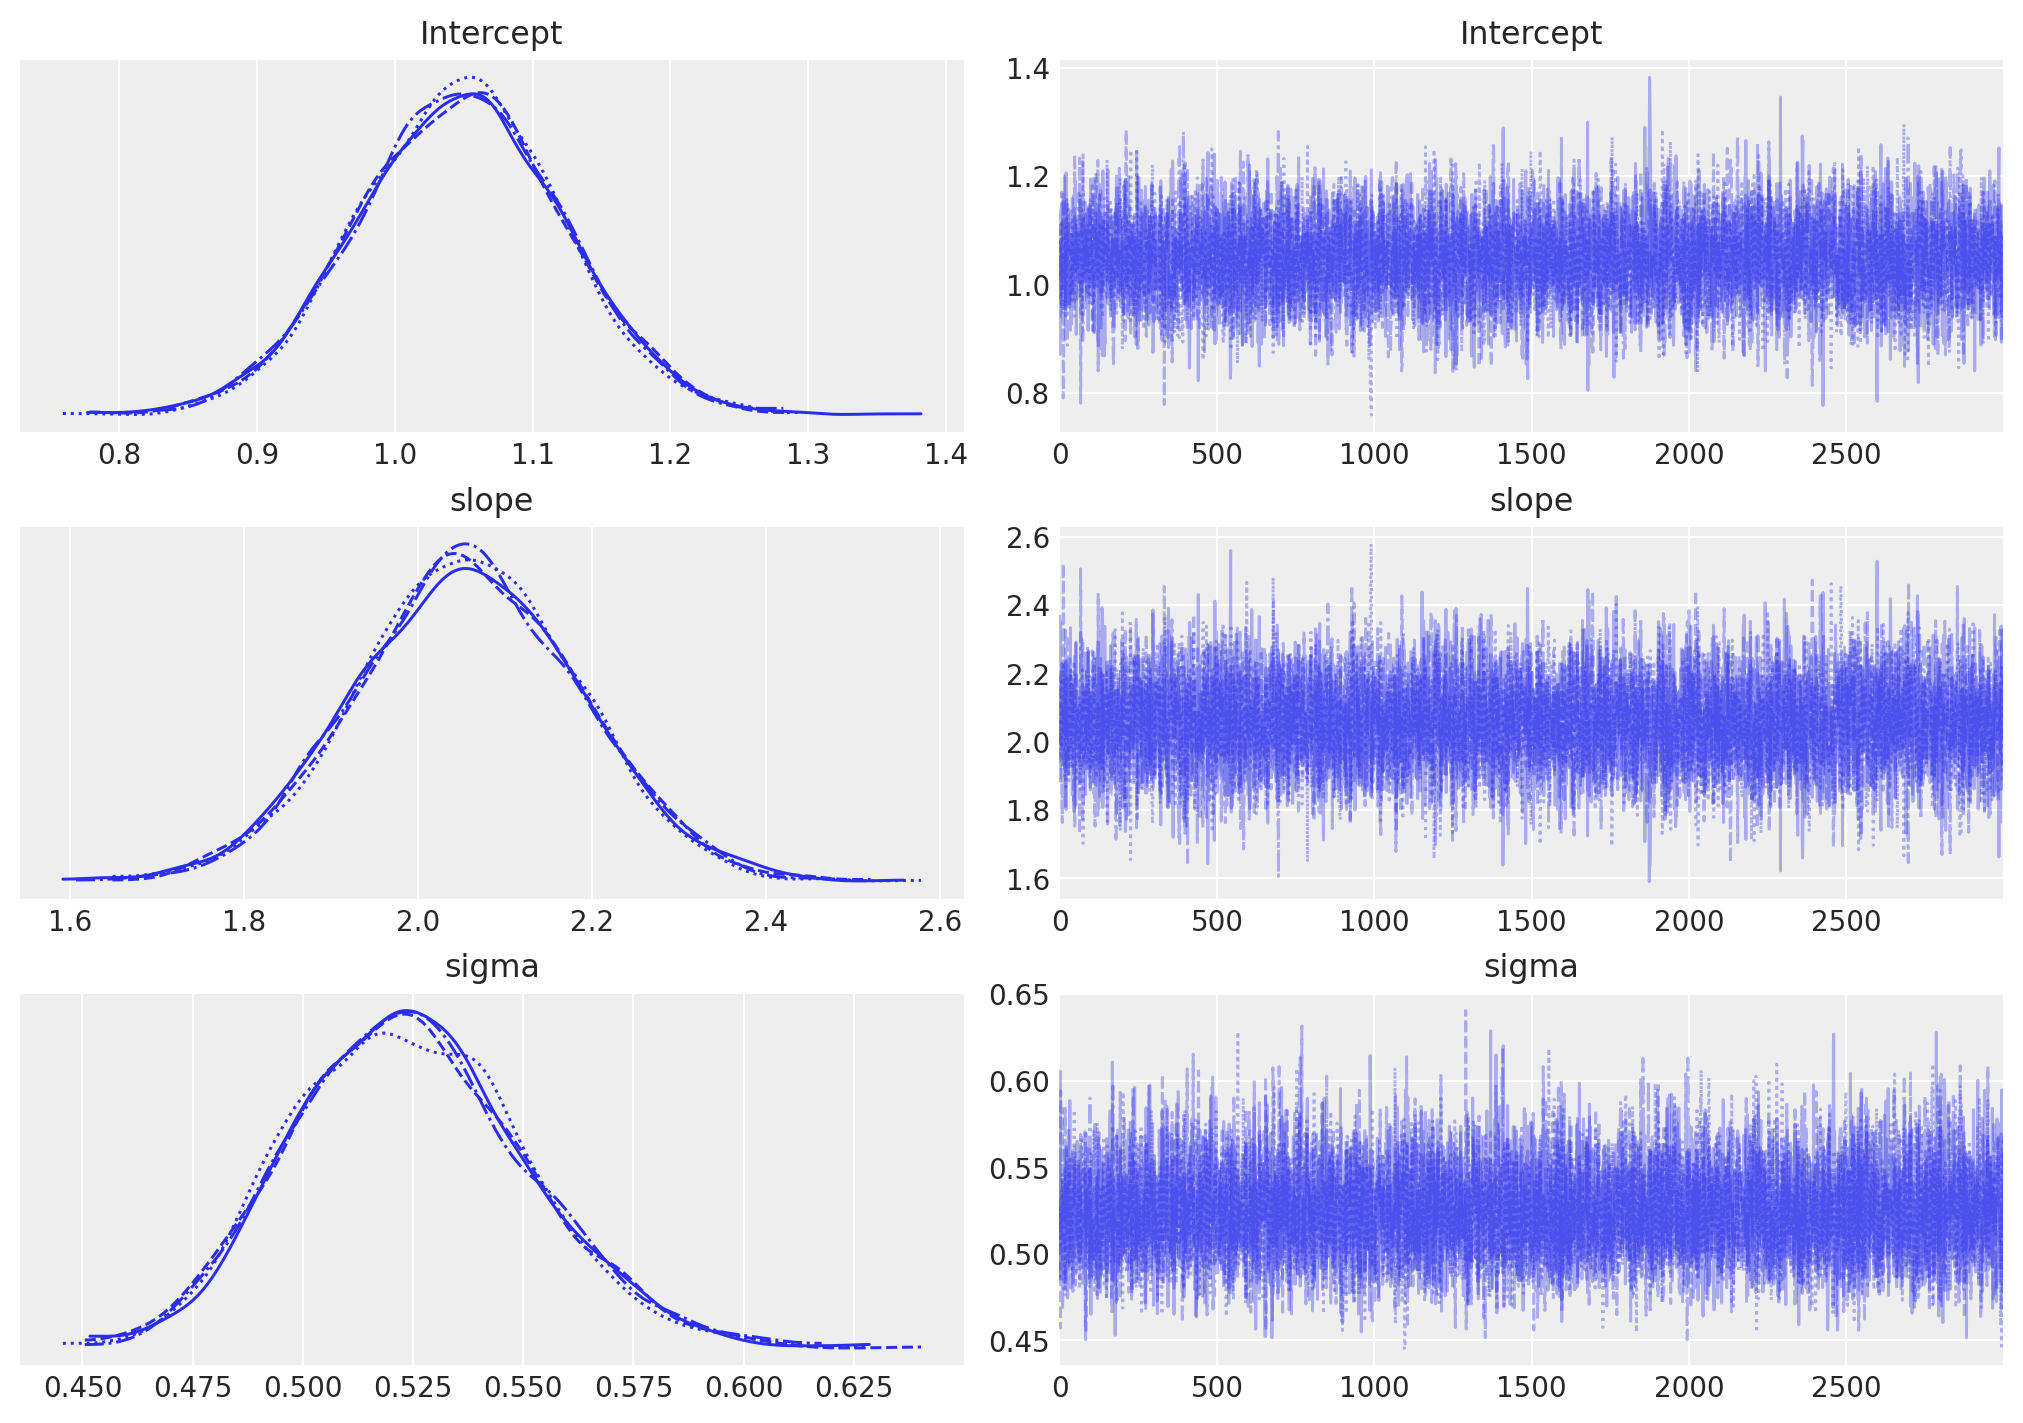

In [7]:
az.plot_trace(idata, figsize=(10, 7));


In [8]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["slope"] * xr.DataArray(x)

/Users/dalarios/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/plots/lmplot.py:212: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


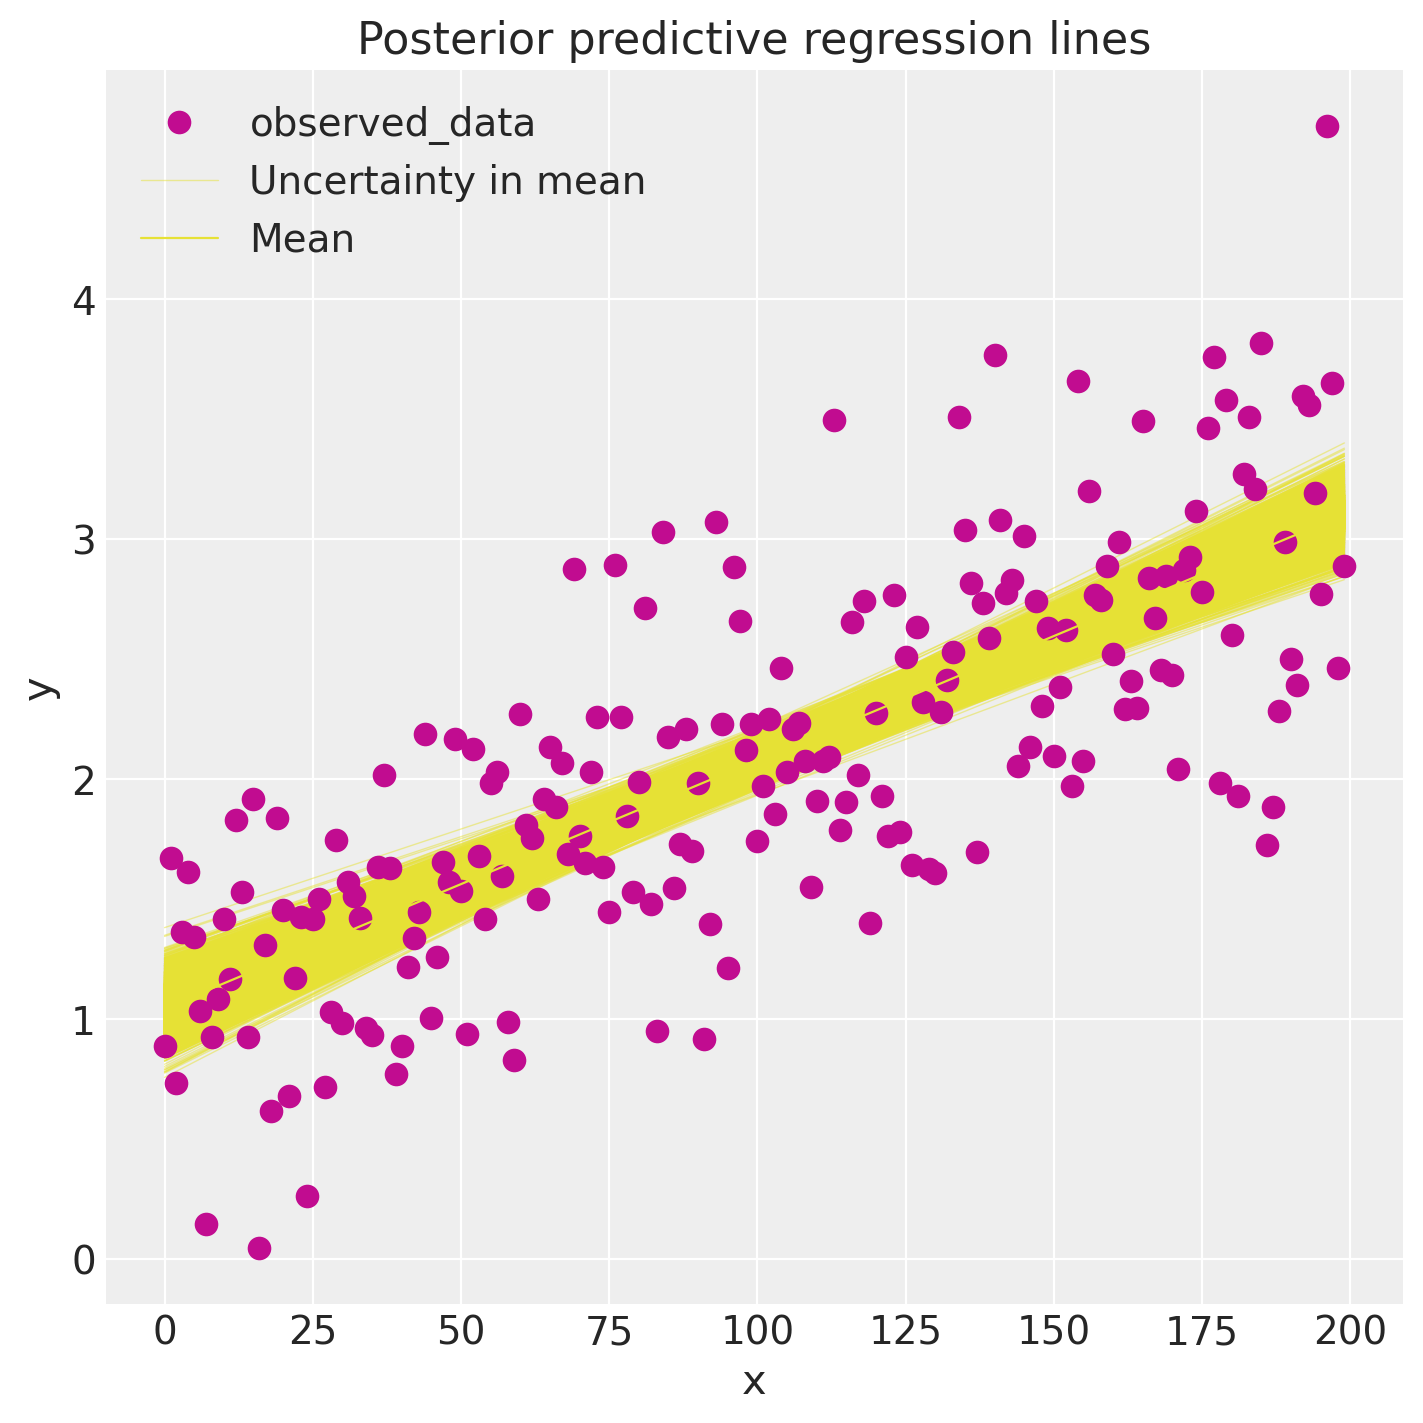

In [9]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=idata, y="y", num_samples=10000, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x");